**Create new dataset based on "Additional datasets":**
* df_Postings_filtered_net
* df_Votes_filtered_net 

**Task:** Predict whether a user will vote  on another user's posting -> we aim at the structure:

User_id (created posting) -- <# of interactions> -- User_id (voted on that posting)

In [1]:
import os
import pandas as pd
from pathlib import Path

In [2]:
os.getcwd()

'/Users/viktoriiaovsianik/Documents/Uni/04_WS2024/05_SNA/02_Project/SNA/exploratory'

In [3]:
# Directory containing your Parquet files
relative_path_to_data = "../data/Additional Data"  # Relative to the current working directory
data_directory = os.path.abspath(relative_path_to_data)

# Path to the file to exclude
#exclude_file_path = '/home/e12217985/shared/194.050-2024W/Data/Group_Project/df_edge_list_undirected_users_click_similarity.parquet'

# Dictionary to store DataFrames with stem names as keys
dataframes = {}

# Iterate over all Parquet files in the directory
for file_path in Path(data_directory).glob("*.parquet"):

    # Extract the file stem (name without extension)
    file_stem = file_path.stem
    print(f"Reading file: {file_stem}")
    
    # Read the Parquet file into a DataFrame
    df = pd.read_parquet(file_path)
    
    # Optionally limit the size of the DataFrame
    #df = df[:20001]
    
    # Store the DataFrame in the dictionary with the stem as the key
    dataframes[file_stem] = df

# Access DataFrames by their file stem
print(dataframes.keys())  # Prints the stems of all loaded files


Reading file: df_ContentPages_filtered_net
Reading file: df_Clicks_net
Reading file: df_Postings_filtered_net
Reading file: df_User_Activeness
Reading file: df_Votes_filtered_net
Reading file: df_Content_DimContentDetails
Reading file: df_CommunityConnection_filtered_net
dict_keys(['df_ContentPages_filtered_net', 'df_Clicks_net', 'df_Postings_filtered_net', 'df_User_Activeness', 'df_Votes_filtered_net', 'df_Content_DimContentDetails', 'df_CommunityConnection_filtered_net'])


In [6]:
vote_timestamps = dataframes['df_Votes_filtered_net']
posting_timestamps = dataframes['df_Postings_filtered_net']

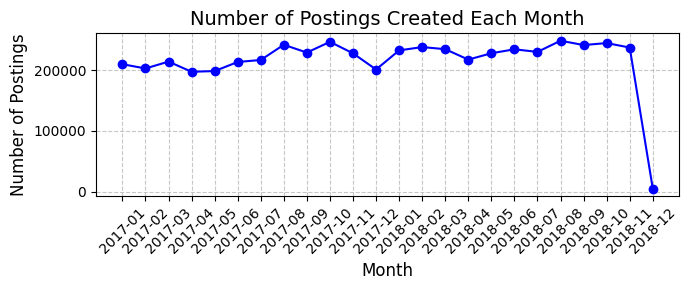

In [ ]:
#Check if there are any months with less postings than usually
from matplotlib import pyplot as plt

posting_timestamps['YearMonth'] = posting_timestamps['createdAt'].dt.to_period('M')

# Group by 'YearMonth' and count the number of postings
monthly_postings = posting_timestamps.groupby('YearMonth').size().reset_index(name='Count')

# Plot the data
plt.figure(figsize=(7, 3))
plt.plot(monthly_postings['YearMonth'].astype(str), monthly_postings['Count'], marker='o', linestyle='-', color='b')

# Customize the chart
plt.title('Number of Postings Created Each Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Postings', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

Since there is no difference between months in the # of postings we can focus on any month.

In [8]:
# Define the date range for filtering
start_date = '2017-11-01'
end_date = '2017-12-01'

#Filter the vote and posting timestamp data by date
def filter_by_date(df, date_column, start_date, end_date):
    df[date_column] = pd.to_datetime(df[date_column])  # Ensure datetime format
    return df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]

# Filter the postings and votes dataframes
filtered_postings = filter_by_date(posting_timestamps, 'createdAt', start_date, end_date)
#filtered_votes = filter_by_date(vote_timestamps, 'CreatedAt', start_date, end_date)

In [9]:
# Merge the datasets using 'ID_Posting' as the key
merged = pd.merge(filtered_postings, vote_timestamps, on='ID_Posting', how='inner')

In [10]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654741 entries, 0 to 654740
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   ID_Posting                    654741 non-null  int64         
 1   ID_Posting_Parent             268572 non-null  float64       
 2   ID_GodotObject_x              654741 non-null  int64         
 3   ID_CommunityIdentity_x        654741 non-null  int64         
 4   createdAt                     654741 non-null  datetime64[ns]
 5   Comment_wo_controlchars_len   654741 non-null  float64       
 6   Headline_wo_controlchars_len  654741 non-null  float64       
 7   YearMonth                     654741 non-null  period[M]     
 8   ID_CommunityIdentity_y        654741 non-null  int64         
 9   VoteNegative                  654741 non-null  bool          
 10  VotePositive                  654741 non-null  bool          
 11  CreatedAt    

In [12]:
#take only information relevant to the task

for_graph = merged[["ID_Posting", "ID_CommunityIdentity_x", "ID_CommunityIdentity_y"]]

In [13]:
#Calculate frequency of every pair
pair_counts = merged.groupby(['ID_CommunityIdentity_x', 'ID_CommunityIdentity_y']).size().reset_index(name='count')

# Display the resulting DataFrame
pair_counts

,ID_CommunityIdentity_x,ID_CommunityIdentity_y,count
0,4,21088,1
1,4,567668,1
2,4,568936,1
3,30,14446,1
4,30,55887,1
...,...,...,...
543022,640065,602673,1
543023,640065,604651,1
543024,640065,605829,2
543025,640065,605947,1


In [15]:
pair_counts["count"].unique()

array([ 1,  2,  3,  4,  5,  7, 10,  8,  6,  9, 24, 11, 20, 27, 12, 42, 19,
       15, 18, 13, 16, 66, 17, 30, 14, 37, 22, 26, 23, 21, 39, 59, 29, 45,
       35, 28, 63, 25, 33, 32, 41, 53, 40, 47, 34, 96, 38, 51, 36, 54, 31,
       77, 50, 76, 46])

In [16]:
pair_counts[pair_counts["count"]==96]

,ID_CommunityIdentity_x,ID_CommunityIdentity_y,count
348419,516017,572366,96


In [17]:
#Example of the pair appeared 96 times
merged[
    (merged["ID_CommunityIdentity_x"] == 516017) & 
    (merged["ID_CommunityIdentity_y"] == 572366)
]

,ID_Posting,ID_Posting_Parent,ID_GodotObject_x,ID_CommunityIdentity_x,createdAt,Comment_wo_controlchars_len,Headline_wo_controlchars_len,YearMonth,ID_CommunityIdentity_y,VoteNegative,VotePositive,CreatedAt,ID_GodotObject_y
485,1025403883,1.025404e+09,2000066961708,516017,2017-11-01 01:56:46.740,698.0,83.0,2017-11,572366,False,True,2017-11-01 18:45:59.993,2000066961708
692,1025404216,1.025404e+09,2000066961708,516017,2017-11-01 03:36:09.933,722.0,106.0,2017-11,572366,False,True,2017-11-01 18:45:53.667,2000066961708
717,1025404275,1.025404e+09,2000066961708,516017,2017-11-01 03:59:46.543,647.0,0.0,2017-11,572366,False,True,2017-11-01 18:45:32.470,2000066961708
9280,1025414857,NaN,2000067001198,516017,2017-11-01 15:15:43.237,99.0,0.0,2017-11,572366,False,True,2017-11-01 15:32:01.420,2000067001198
10007,1025415603,NaN,2000067001198,516017,2017-11-01 15:55:24.637,201.0,0.0,2017-11,572366,False,True,2017-11-01 17:17:08.850,2000067001198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
643492,1026234680,NaN,2000068797511,516017,2017-11-30 14:17:33.030,721.0,0.0,2017-11,572366,False,True,2017-11-30 14:58:52.070,2000068797511
645352,1026236609,1.026233e+09,2000068797511,516017,2017-11-30 15:22:59.750,11.0,0.0,2017-11,572366,False,True,2017-11-30 16:09:54.653,2000068797511
646365,1026237865,NaN,2000068797511,516017,2017-11-30 16:01:23.230,369.0,0.0,2017-11,572366,False,True,2017-11-30 16:02:27.553,2000068797511
649068,1026241252,1.026241e+09,2000068797511,516017,2017-11-30 17:51:05.907,426.0,0.0,2017-11,572366,False,True,2017-12-01 00:07:31.427,2000068797511


Prepaire graph

In [19]:
# 1. Convert the directed votes dataset into a graph
import networkx as nx

G = nx.from_pandas_edgelist(
    pair_counts,  # Replace with your DataFrame variable
    source="ID_CommunityIdentity_x",
    target="ID_CommunityIdentity_y",
    edge_attr="count",  # Optional: edge weights
    create_using=nx.Graph()  # Ensure a non directed graph
)

In [21]:
#Check size of the graph

print("# of nodes in G:", G.number_of_nodes())
print("# of edges in G:", G.number_of_edges())

# of nodes in G: 10964
# of edges in G: 529434


In [22]:
subgraph = G.subgraph(list(G.nodes)[:100])  # Adjust size

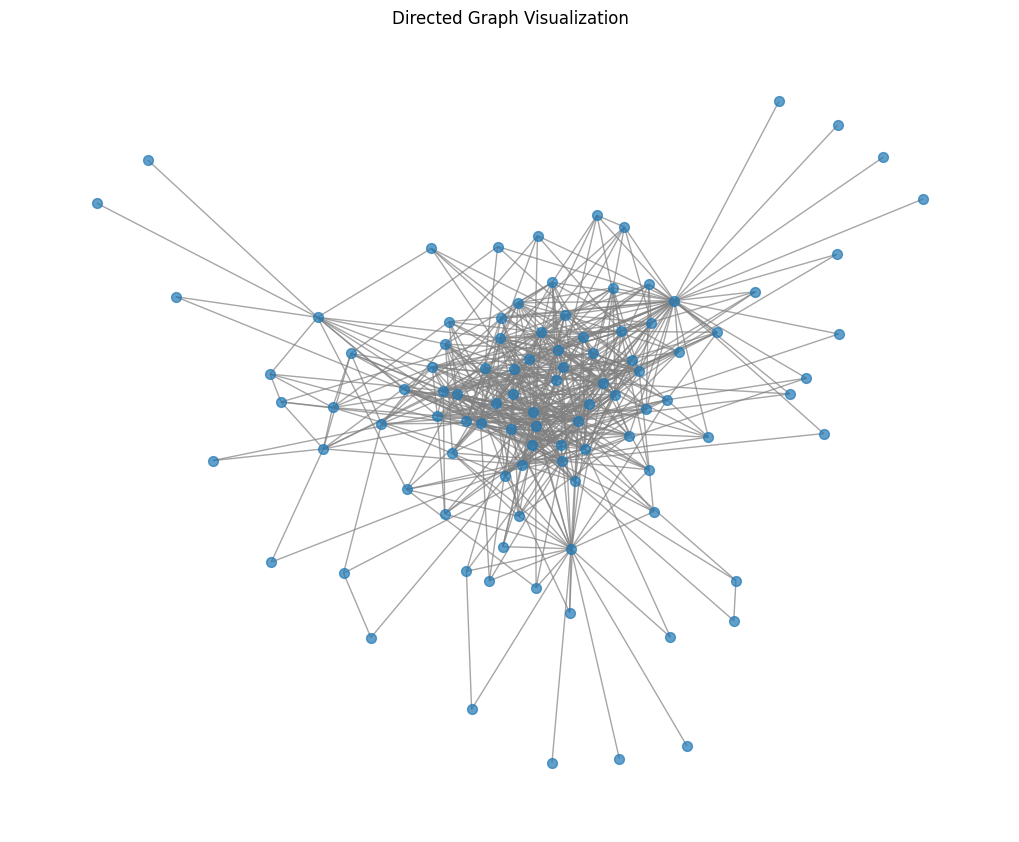

In [23]:
# Visualize the subgraph with basic layout
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph)
nx.draw(
    subgraph,
    pos,
    with_labels=False,
    node_size=50,
    edge_color='gray',
    alpha=0.7
)
plt.title("Directed Graph Visualization")
plt.show()